# ES1333/5, Final Project: Tumor classification from gene expression data

The provided dataset contains RNA quantities of 3000 corresponding genes for each recorded tumor. Each tumor is labeled as breast or ovarian tumor. The goal of this mini-project is to build a binary classifier of breast vs. ovarian tumors using this dataset.

## Load and preprocess data

Required packages are imported and helper functions are defined in the cell below.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import clear_output

def PlotConfusionMatrix(y_true, y_pred):
    """Plot confusion matrix given true and predicted labels."""
    plt.figure(figsize=(5, 5));
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, 
                cmap="BuPu", cbar=False);
    plt.title("Confusion Matrix");
    plt.xlabel("Predicted Label");
    plt.ylabel("True Label");

The dataset is loaded and the `Tissue` column containing the labels is binarized.

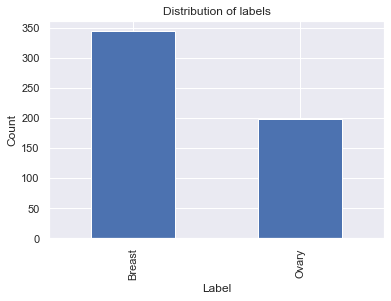

In [41]:
# Load dataset and binarize "Tissue" column.
bvo_df = pd.read_csv('small_Breast_Ovary.csv')

# Plot distribution of labels.
ax = bvo_df.Tissue.value_counts().plot.bar()
ax.set(title='Distribution of labels', xlabel='Label', ylabel='Count')

# Binarize labels.
bvo_df['Tissue'] = np.where(bvo_df['Tissue'] == 'Breast', 0, 1)

The `ID_REF` column is a unique identifier for each tumor: it is dropped as it is useless for classification. The dataset is then separated into training and test sets (ratio 90/10), stratifying on the tumor labels. The features (RNA quantities of each gene) are then standardized.

In [42]:
# Extract features.
features = bvo_df.drop(columns=['ID_REF', 'Tissue'])

# Extract labels and convert to 0 ("Breast") and 1 ("Ovarian").
labels = bvo_df['Tissue']

# Separate into training and test sets, stratifying on labels.
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42, stratify=labels
)
print('Number of examples in the training set:', X_train.shape[0])
print('Number of examples in the test set:', X_test.shape[0])

# Standardize training and test sets.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Number of examples in the training set: 487
Number of examples in the test set: 55


## Exploratory data analysis

To get a first picture of our dataset, we might want to know if the features are correlated. Seeing that the dataset contains 3000 features, we will first look at the correlation matrix of the first one hundred.

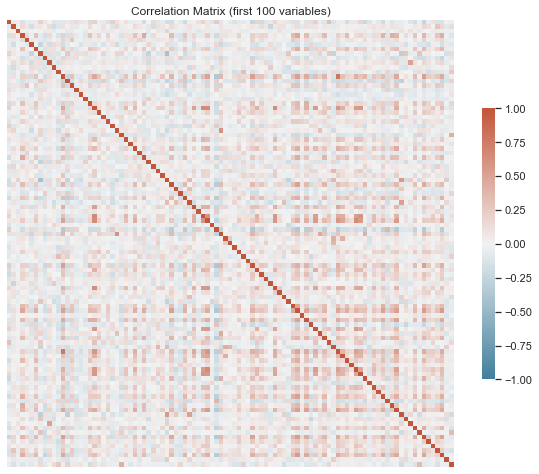

In [43]:
# Compute correlation matrix.
corr_mat = bvo_df.iloc[:, 1:100].corr()

# Generate a custom diverging colormap.
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the correct aspect ratio.
plt.figure(figsize=(10, 10));
sns.heatmap(corr_mat, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, xticklabels=False, yticklabels=False,
            cbar_kws={"shrink": 0.5})
plt.title('Correlation Matrix (first 100 variables)');

Seeing that many features are highly correlated, the first principal component of our data will likely dominate. We will try to visualize the dataset using the first two principal components anyway, but shouldn't be too hopefull about the ability of this projection to clusterize our data.

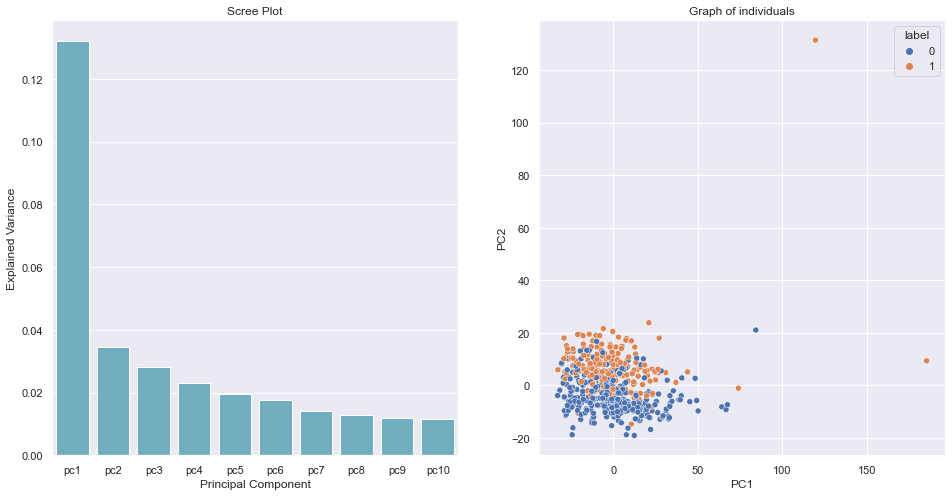

In [45]:
# Standardize whole dataset.
sc = StandardScaler()
features_norm = sc.fit_transform(features)

# Perform PCA.
pca = PCA()
pc = pca.fit_transform(features_norm)

# Store results in DataFrames.
pc_df = pd.DataFrame(
    data = pc[:, :10],
    columns = ['pc{}'.format(i+1) for i in range(10)] 
)
pc_df['label'] = labels
explained_var_df = pd.DataFrame({
    'var': pca.explained_variance_ratio_[:10],
    'pc': ['pc{}'.format(i+1) for i in range(10)] 
})

# Plot screeplot.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8));
sns.barplot(x='pc', y='var', data=explained_var_df, color='c', ax=ax1)
ax1.set(title='Scree Plot',
        xlabel='Principal Component',
        ylabel='Explained Variance');
sns.scatterplot(x='pc1', y='pc2', data=pc_df, hue='label', ax=ax2);
ax2.set(title='Graph of individuals',
        xlabel='PC1',
        ylabel='PC2');

As expected, the first princpal component explains a lot more variance than any other. The first two principal components don't do a good job at discriminating between breast and ovary tumors, but we can still see two overlapping clusters separated by the second principal component. Furthermore, we can see some outliers that we should study more precisely.

## Building a binary classifier

We are interested in building a classifier of tumors. After some preliminary testing, two methods were selected: **Random Forests** and **AdaBoost**. Optimal hyperparameters will be grid-searched and selected using 5-fold cross-validation. Results will be displayed as confusion matrices.

Best parameters:  {'max_depth': 10, 'n_estimators': 200}
Accuracy on test set:  0.9272727272727272


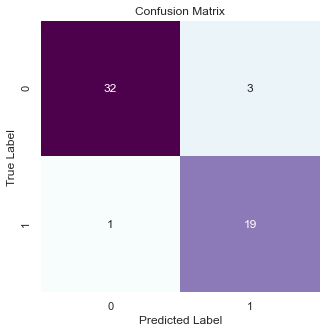

In [56]:
# Parameter grid for Random Forests grid-search.
param_grid = {'n_estimators' : np.arange(100, 500, 50),
              'max_depth': [5, 10, 15, None]}

# Perform grid-search with 5-fold CV.
rdf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=param_grid, 
                   n_jobs=-1, verbose=2)
rdf.fit(X_train,y_train)

clear_output()

print('Best parameters: ', rdf.best_params_)
score = rdf.score(X_test, y_test)
print("Accuracy on test set: ", score)

PlotConfusionMatrix(y_test, rdf.predict(X_test))

Acuracy (on test set) =  0.9629629629629629


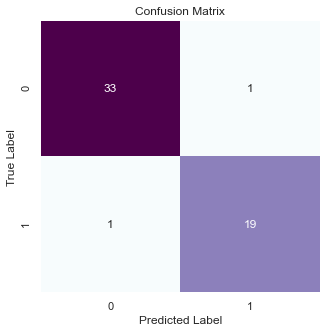

In [95]:
# Parameter grid for AdaBoost grid-search.
param_grid = {'n_estimators' : np.arange(100, 500, 50),
              'base_estimator__max_depth': [5, 10, 15, None]}

abc = AdaBoostClassifier()
abc = abc.fit(X_train, y_train)

clear_output()

print('Best parameters: ', abc.best_params_)
score = abc.score(X_test, y_test)
print("Accuracy on test set: ", score)

PlotConfusionMatrix(y_test, abc.predict(X_test))